# Set Up

Imports

In [1]:
# general imports
import argparse
import sys
import pandas as pd
import matplotlib.pyplot as plt

# imports for master dict
import os
import json
import numpy as np

# imports for placesCNN()
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image

Master Dict Class

In [2]:
#----------------------------------------------------------------------
# MASTER_DICT
# get all the important information you need
# that does not require opening the blender file
def getMasterDict(dataset_path, scene_id):
    # Conversion_dicts
    # dicts to convert between object-indicies to solve_state_json_names and blender_names
    indexToBlender = {}
    blenderToIndex = {}
    jsonToBlender = {}
    blenderToJson = {}

    # get all object indecies from the objectsegmentation array
    # frames/ObjectSegmentation/camera_0/ObjectSegmentation_0_0_0048_0.npy
    obj_seg_path = os.path.join( dataset_path, scene_id, "frames", "ObjectSegmentation", "camera_0", "ObjectSegmentation_0_0_0048_0.npy")
    obj_seg_arr = np.load(obj_seg_path)
    obj_seg_set = set( obj_seg_arr.flatten() )
    if 0 in obj_seg_set:
        obj_seg_set.remove(0) # remove 0 from set

    # go through objects.json, find all matching objects, and update the conversion_dicts
    obj_json_path = os.path.join( dataset_path, scene_id, "frames", "Objects", "camera_0", "Objects_0_0_0048_0.json")
    with open( obj_json_path, "r") as obj_json_file:
        obj_json_map = json.load(obj_json_file)
    
    for key, meta in obj_json_map.items():
        blender_obj_name = key
        obj_index = meta["object_index"]
        if obj_index in obj_seg_set:
            indexToBlender[obj_index] = blender_obj_name
            blenderToIndex[blender_obj_name] = obj_index
    
    # print("PRE-FILTERING: Blender-Index Conversions: ", "Number of enteries: ", len(indexToBlender))
    # print("IndexToBlender: ", indexToBlender)
    # print("BlenderToIndex: ", blenderToIndex)
    # print("\n", flush = True)

    # filter out unwanted objects
    filtered_list = [] # a list of (obj, index) to be removed
    filter_set = {"kitchen_0", "living-room_0", "dining-room_0", "bedroom_0", "bathroom_0"}
    for blender_obj_name, obj_index in blenderToIndex.items():
        for filter_item in filter_set:
            if filter_item in blender_obj_name:
                filtered_list.append( (blender_obj_name, obj_index) )
                break

    for blender_obj_name, obj_index in filtered_list:
        blenderToIndex.pop(blender_obj_name)
        indexToBlender.pop(obj_index)

    # populate dicts for blender_obj_names to and from solve_state_json_obj_names
    solve_state_json_path = os.path.join( dataset_path, scene_id, "coarse", "solve_state.json" )
    with open(solve_state_json_path, "r") as solve_state_json_file:
        solve_state_json_map = json.load(solve_state_json_file)
        solve_state_json_map = solve_state_json_map["objs"] # unpack objs
    for key, meta in solve_state_json_map.items():
        if meta['obj'] in blenderToIndex:
            json_obj_name = key
            blender_obj_name = meta['obj']
            blenderToJson[blender_obj_name] = json_obj_name
            jsonToBlender[json_obj_name] = blender_obj_name
    # json has less objects than index and blender
    for obj_blender_name in blenderToIndex.keys():
        if obj_blender_name not in blenderToJson:
            blenderToJson[obj_blender_name] = None

    # print("Filter: ", "removedCount:", len(filtered_list), "remainingCount", len(blenderToIndex))
    # print("removed: ", filtered_list)
    # print("remaining: ", blenderToIndex.keys())
    # print("POST-FILTER: (index: blender : json)")
    # for obj_index, blender_obj_name in indexToBlender.items():
    #     print(f"{obj_index}: {blender_obj_name} : {blenderToJson[blender_obj_name]}")
    # print("\n", flush = True)


    # for each object (blender_name), map it to a list of 'dependents' that depend on it
    # i.e. table should map to all the plates on the table
    # use blender names for objects
    dependents_map = {}

    for root in blenderToIndex.keys():
        # run bfs
        queue = [ root ]
        dependents = set() # fill it with all objects connected to parent
        visited = { root } # technically not needed since you can only depend on one thing and there are no cycles
        while queue:
            # process current object by adding it to dependents set
            curr_obj_blender = queue.pop(0)
            if curr_obj_blender != root: # don't include the root as a dependent
                dependents.add( curr_obj_blender )

            # put all eligible children in the queue

            # Objects.json condition...
            # accept children of curr_obj_blender
            for child_index in obj_json_map[curr_obj_blender]["children"]:
                if child_index in indexToBlender and indexToBlender[child_index] not in visited:
                    visited.add( indexToBlender[child_index] )
                    queue.append( indexToBlender[child_index] )
            
            # Solve_state.json condition...
            if not blenderToJson[curr_obj_blender]: # some blender objs are not listed in obj
                continue
            for key in jsonToBlender.keys():
                if jsonToBlender[key] in visited:
                    continue
                for rel in solve_state_json_map[key]["relations"]:
                    target_name = rel["target_name"]
                    relation_type = rel["relation"]["relation_type"]
                    child_tags = rel["relation"]["child_tags"]
                    if (target_name == blenderToJson[curr_obj_blender]
                            and relation_type == "StableAgainst"
                            and "Subpart(bottom)" in child_tags
                    ):
                        visited.add( jsonToBlender[key] )
                        queue.append( jsonToBlender[key] )
        dependents_map[ root ] = dependents

    # print out pretty formatted dependents_map
    # def set_default(obj):
    #     if isinstance(obj, set):
    #         return list(obj)
    #     raise TypeError
    # pretty_print = json.dumps( dependents_map, indent=2, default=set_default )
    # print( "Dependents_map: ", pretty_print )

    # categorize objects by groups
    # create maps from groups to objects and vice versa
    groupToObjects = {}
    objectToGroup = {}
    for blender_obj_name in blenderToIndex.keys():
        index = blender_obj_name.find("Factory")
        if index != -1:
            group_name = blender_obj_name[:index]
        else:
            group_name = blender_obj_name
        objectToGroup[blender_obj_name] = group_name
        if group_name in groupToObjects:
            groupToObjects[group_name].append(blender_obj_name)
        else:
            groupToObjects[group_name] = [ blender_obj_name ]
    
    masterDict = {
        # our 4 name conversion dictionaries
        "indexToBlender": indexToBlender,
        "blenderToIndex": blenderToIndex,
        "jsonToBlender": jsonToBlender,
        "blenderToJson": blenderToJson,

        # relational dependencies
        "dependents_map": dependents_map,
        "groupToObjects": groupToObjects,
        "objectToGroup": objectToGroup,

        "obj_seg_arr": obj_seg_arr, #from objectSegmentation.npy
    }
    return masterDict
#----------------------------------------------------------------------

PlacesCNN Class

In [3]:
#----------------------------------------------------------------------
# PLACES365_RESNET
class placesCNN():
    def __init__(self):
        """
        saves model, centre_crop, and classes as instance variables
        model and centre_crop are used in predict()
        classes[i] is the class name of the ith class
        """
        # th architecture to use
        arch = 'resnet18'

        # load the pre-trained weights
        model_file = '%s_places365.pth.tar' % arch
        if not os.access(model_file, os.W_OK):
            weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
            os.system('wget ' + weight_url)

        model = models.__dict__[arch](num_classes=365)
        checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
        state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)
        model.eval()


        # load the image transformer
        centre_crop = trn.Compose([
                trn.Resize((256,256)),
                trn.CenterCrop(224),
                trn.ToTensor(),
                trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # load the class label
        file_name = 'categories_places365.txt'
        if not os.access(file_name, os.W_OK):
            synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
            os.system('wget ' + synset_url)
        classes = list()
        with open(file_name) as class_file:
            for line in class_file:
                classes.append(line.strip().split(' ')[0][3:])
        classes = tuple(classes)

        # variables we care about
        self.model= model
        self.centre_crop = centre_crop
        self.classes = classes
    
    def predict(self, img_path):
        """
        Returns h_x, probs, idx
        h_x[i] is model's prediction for class i
        probs[i] is the model's prediction for the ith highest class
        idx[i] is the class index corresponding to the ith highest class
        """
        img = Image.open(img_path).convert("RGB")
        input_img = V(self.centre_crop(img).unsqueeze(0)) # preprocess & batchify

        # forward pass
        logit = self.model(input_img)
        h_x = F.softmax(logit, 1).data.squeeze()
        probs, idx = h_x.sort(0, True)

        return h_x, probs, idx
#----------------------------------------------------------------------

# Equirectangular Data Analysis

In [ ]:
output_path = "/n/fs/obj-cv/experiment_project/sites/bathroom97Site/results" # path with the equirect and normal images
data_write_folder = "/n/fs/obj-cv/experiment_project/experiments/equirectangularDataAnalysis" # "output" folder for where all the data gets written to

CNN = placesCNN()

output_path_arr = [
    "/n/fs/obj-cv/experiment_project/sites/kitchen94Site/results",
    "/n/fs/obj-cv/experiment_project/sites/bathroom97Site/results",
    "/n/fs/obj-cv/experiment_project/sites/livingRoom99Site/results",
    "/n/fs/obj-cv/experiment_project/sites/diningRoom99Site/results",
    "/n/fs/obj-cv/experiment_project/sites/bedroom96Site/results"
]

# hard coded ground truth
ground_arr = [
    203, # kitchen
    45, # bathroom
    215, # livingroom
    121, # diningroom
    52 # bedroom
]

# data_table. Building a data table that we can put into pandas later
data_table = []


for ground_id, output_path in zip( ground_arr, output_path_arr ):

    ground_name = CNN.classes[ground_id]

    # go through each scene_id
    for index, scene_id in enumerate( sorted(os.listdir( output_path ))):
        print( ground_name, index )
        # early stop
        # if index == 2:
        #     print("Early Stop. Exiting...", file=sys.stderr)
        #     break

        # get normal image and equirect image
        n_img = os.path.join( output_path, scene_id, "Normal_Image.png" )
        e_img = os.path.join( output_path, scene_id, "Equirect_Image.png" )

        # get model resutls for normal image
        h_x, probs, idx = CNN.predict( n_img )
        n_ground_prob = h_x[ ground_id ]
        n_top_prob = probs[ 0 ]
        n_top_name = CNN.classes[idx[0]]

        # get model results for equirect image
        h_x, probs, idx = CNN.predict( e_img )
        e_ground_prob = h_x[ ground_id ]
        e_top_prob = probs[0]
        e_top_name = CNN.classes[idx[0]]

        # create a row that will be added to the data table
        row_dict = {
            "groundName": ground_name,
            "groundId": ground_id,
            "sceneId": scene_id,
            "normGroundProb": n_ground_prob,
            "normTopProb": n_top_prob,
            "normTopName": n_top_name,
            "equiGroundProb": e_ground_prob,
            "equiTopProb": e_top_prob,
            "equiTopName": e_top_name,
            "deltaGroundProb": e_ground_prob - n_ground_prob, # equi - norm
            "deltaTopProb": e_top_prob - n_top_prob
        }

        # take out of tensor and round to 5 decimal places
        row_dict["normGroundProb"] = round(row_dict["normGroundProb"].item(), 5)
        row_dict["normTopProb"] = round(row_dict["normTopProb"].item(), 5)
        row_dict["equiGroundProb"] = round(row_dict["equiGroundProb"].item(), 5)
        row_dict["equiTopProb"] = round(row_dict["equiTopProb"].item(), 5)
        row_dict["deltaGroundProb"] = round(row_dict["deltaGroundProb"].item(), 5)
        row_dict["deltaTopProb"] = round(row_dict["deltaTopProb"].item(), 5)

        data_table.append( row_dict )


/tmp/ipykernel_361970/1523398849.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)


kitchen 0
kitchen 1
kitchen 2
kitchen 3
kitchen 4
kitchen 5
kitchen 6
kitchen 7
kitchen 8
kitchen 9
kitchen 10
kitchen 11
kitchen 12
kitchen 13
kitchen 14
kitchen 15
kitchen 16
kitchen 17
kitchen 18
kitchen 19
kitchen 20
kitchen 21
kitchen 22
kitchen 23
kitchen 24
kitchen 25
kitchen 26
kitchen 27
kitchen 28
kitchen 29
kitchen 30
kitchen 31
kitchen 32
kitchen 33
kitchen 34
kitchen 35
kitchen 36
kitchen 37
kitchen 38
kitchen 39
kitchen 40
kitchen 41
kitchen 42
kitchen 43
kitchen 44
kitchen 45
kitchen 46
kitchen 47
kitchen 48
kitchen 49
kitchen 50
kitchen 51
kitchen 52
kitchen 53
kitchen 54
kitchen 55
kitchen 56
kitchen 57
kitchen 58
kitchen 59
kitchen 60
kitchen 61
kitchen 62
kitchen 63
kitchen 64
kitchen 65
kitchen 66
kitchen 67
kitchen 68
kitchen 69
kitchen 70
kitchen 71
kitchen 72
kitchen 73
kitchen 74
kitchen 75
kitchen 76
kitchen 77
kitchen 78
kitchen 79
kitchen 80
kitchen 81
kitchen 82
kitchen 83
kitchen 84
kitchen 85
kitchen 86
kitchen 87
kitchen 88
kitchen 89
kitchen 90
kitchen 9

In [6]:
data_table

[{'groundName': 'kitchen',
  'groundId': 203,
  'sceneId': '11c1b5c0',
  'normGroundProb': 0.04063,
  'normTopProb': 0.38936,
  'normTopName': 'home_theater',
  'equiGroundProb': 0.00061,
  'equiTopProb': 0.24304,
  'equiTopName': 'lobby',
  'deltaGroundProb': -0.04003,
  'deltaTopProb': -0.14632},
 {'groundName': 'kitchen',
  'groundId': 203,
  'sceneId': '12f16d0c',
  'normGroundProb': 0.01532,
  'normTopProb': 0.2233,
  'normTopName': 'server_room',
  'equiGroundProb': 0.00039,
  'equiTopProb': 0.37287,
  'equiTopName': 'attic',
  'deltaGroundProb': -0.01493,
  'deltaTopProb': 0.14958},
 {'groundName': 'kitchen',
  'groundId': 203,
  'sceneId': '1420624e',
  'normGroundProb': 0.35361,
  'normTopProb': 0.35361,
  'normTopName': 'kitchen',
  'equiGroundProb': 0.05932,
  'equiTopProb': 0.52592,
  'equiTopName': 'wet_bar',
  'deltaGroundProb': -0.29429,
  'deltaTopProb': 0.17231},
 {'groundName': 'kitchen',
  'groundId': 203,
  'sceneId': '15ba83e1',
  'normGroundProb': 0.00957,
  'norm

In [8]:
df = pd.DataFrame(data_table)
data_write_folder = "/n/fs/obj-cv/experiment_project/experiments/equirectangularDataAnalysis"
with open(os.path.join(data_write_folder, "rawData.csv"), "w") as file:
    file.write(df.to_csv())

In [9]:
csv_path = os.path.join( data_write_folder, "rawData.csv" )
df = pd.read_csv( csv_path )
df

,Unnamed: 0,groundName,groundId,sceneId,normGroundProb,normTopProb,normTopName,equiGroundProb,equiTopProb,equiTopName,deltaGroundProb,deltaTopProb
0,0,kitchen,203,11c1b5c0,0.04063,0.38936,home_theater,0.00061,0.24304,lobby,-0.04003,-0.14632
1,1,kitchen,203,12f16d0c,0.01532,0.22330,server_room,0.00039,0.37287,attic,-0.01493,0.14958
2,2,kitchen,203,1420624e,0.35361,0.35361,kitchen,0.05932,0.52592,wet_bar,-0.29429,0.17231
3,3,kitchen,203,15ba83e1,0.00957,0.18078,basement,0.00092,0.16380,attic,-0.00865,-0.01698
4,4,kitchen,203,16570afb,0.02910,0.34674,sauna,0.00095,0.34323,bathroom,-0.02815,-0.00350
...,...,...,...,...,...,...,...,...,...,...,...,...
480,480,bedroom,52,98d921,0.00058,0.34215,locker_room,0.01389,0.15867,entrance_hall,0.01331,-0.18348
481,481,bedroom,52,a2bf14e,0.12760,0.61229,youth_hostel,0.01603,0.08925,train_interior,-0.11157,-0.52304
482,482,bedroom,52,a52843b,0.05010,0.27891,berth,0.01811,0.31716,attic,-0.03199,0.03825
483,483,bedroom,52,c981bb0,0.04949,0.35411,television_room,0.00101,0.29694,artists_loft,-0.04848,-0.05717


In [12]:
df_ground = (
    df.groupby(
        "groundName"
    ).agg(
        avgNormGroundProb = ('normGroundProb', 'mean'),
        avgEquiGroundProb = ('equiGroundProb', 'mean'),
        avgDeltaGroundProb = ('deltaGroundProb', 'mean'),
    )
)

df_ground

,avgNormGroundProb,avgEquiGroundProb,avgDeltaGroundProb
groundName,,,
bathroom,0.196659,0.154397,-0.042262
bedroom,0.059615,0.015916,-0.043699
dining_room,0.063248,0.012063,-0.051185
kitchen,0.055899,0.005017,-0.050882
living_room,0.036275,0.022756,-0.013519


In [13]:
df_top = (
    df.groupby(
        "groundName"
    ).agg(
        avgNormTopProb = ('normTopProb', 'mean'),
        avgEquiTopProb = ('equiTopProb', 'mean'),
        avgDeltaTopProb = ('deltaTopProb', 'mean'),
    )
)

df_top

,avgNormTopProb,avgEquiTopProb,avgDeltaTopProb
groundName,,,
bathroom,0.432168,0.278294,-0.153874
bedroom,0.333111,0.267383,-0.065729
dining_room,0.313037,0.248740,-0.064297
kitchen,0.337367,0.270879,-0.066487
living_room,0.308953,0.282762,-0.026192


# Object Count Data

In [87]:
# get each of the raw data csv files
raw_data_df_arr = []
data_folder = "/n/fs/obj-cv/experiment_project/experiments/objRemovalExp/dataFolder"
for ground_data in sorted( os.listdir(data_folder) ):
    df = pd.read_csv( os.path.join(data_folder, ground_data, "rawData.csv") )
    raw_data_df_arr.append(df)

# get the dataset paths as well
dataset_path_arr = []
dataset_folder = "/n/fs/obj-cv/infinigen_project/savedDatasets"
for ground_data in sorted( os.listdir(dataset_folder) ):
    dataset_path_arr.append( os.path.join( dataset_folder, ground_data) )

print(dataset_path_arr)
for df in raw_data_df_arr:
    print( df.loc[0]["groundName"] )


['/n/fs/obj-cv/infinigen_project/savedDatasets/bathroom97', '/n/fs/obj-cv/infinigen_project/savedDatasets/bedroom96', '/n/fs/obj-cv/infinigen_project/savedDatasets/diningRoom99', '/n/fs/obj-cv/infinigen_project/savedDatasets/kitchenDataset94', '/n/fs/obj-cv/infinigen_project/savedDatasets/livingRoom99']
bathroom
bedroom
dining_room
kitchen
living_room


In [88]:
# filter so that you only keep columns corresponding to single objects
for i, df in enumerate(raw_data_df_arr):
    raw_data_df_arr[i] = df[ df["isSingle"] ]
    print(raw_data_df_arr[i].head())

# additional filters to only take columns with large objects
# for i, df in enumerate(raw_data_df_arr):
#     raw_data_df_arr[i] = df[ df["cumPixelsPercent"] > 0.02 ]
#     print(raw_data_df_arr[i].head())

   Unnamed: 0                                            imgName   sceneId  \
0           0  HardwareFactory(1916075).spawn_asset(1950404).png  119488bb   
1           1  NatureShelfTrinketsFactory(6621866).spawn_asse...  119488bb   
2           2       PanelDoorFactory(1938472).spawn_asset(0).png  119488bb   
3           3  PlantContainerFactory(7655784).spawn_asset(965...  119488bb   
4           4  SimpleBookcaseFactory(2981750).spawn_asset(692...  119488bb   

   modelGroundProb  modelOrigProb  normGroundProb  normOrigProb  normOrigIdx  \
0           0.2154         0.2154          0.2436        0.2436           45   
1           0.2035         0.2035          0.2436        0.2436           45   
2           0.1977         0.1977          0.2436        0.2436           45   
3           0.1619         0.1619          0.2436        0.2436           45   
4           0.0293         0.0293          0.2436        0.2436           45   

  normOrigName  deltaGroundProb  deltaOrigProb    

In [ ]:
# OPTIONAL CELL: data not saved
# for each df group by sceneId and extract the normal score as well as object count
optional_arr = []
for df in raw_data_df_arr:
    df = df.groupby(
        "sceneId"
    ).agg(
        normGroundProb  = ( 'normGroundProb', 'mean' ),
        normOrigProb = ( 'normOrigProb', 'mean'),
        objectCount = ( 'sceneId', 'count' ),
        groundName = ( 'groundName', 'first' ),

    )
    optional_arr.append(df)
    # print(df.head())

# OPTIONAL CELL 1: data not saved
# before concating, let's groupby groundName and get the average object counts for each scene
df = pd.concat(optional_arr)
df = df.groupby( "groundName" ).agg(
    avgObjectCount = ( 'objectCount', 'mean' ),
    stdObjectCount = ( 'objectCount', 'std' )
)
means = df.mean(numeric_only=True)
df.loc["average"] = means
df


,avgObjectCount,stdObjectCount
groundName,,
bathroom,11.597938,5.094237
bedroom,20.457447,9.251172
dining_room,18.568421,7.477132
kitchen,11.936170,5.990689
living_room,16.101010,6.551982
average,15.732197,6.873042


In [ ]:
# for each df group by sceneId and extract the normal score as well as object count
for i, df in enumerate(raw_data_df_arr):
    raw_data_df_arr[i] = df.groupby(
        "sceneId"
    ).agg(
        normGroundProb  = ( 'normGroundProb', 'mean' ),
        normOrigProb = ( 'normOrigProb', 'mean'),
        objectCount = ( 'sceneId', 'count' )
    )
    print(raw_data_df_arr[i].head())

          normGroundProb  normOrigProb  objectCount
sceneId                                            
119488bb          0.2436        0.2436            7
12964af1          0.0005        0.0728           13
14c81791          0.0075        0.1961           13
16358071          0.0190        0.1141           19
169a7ea3          0.5492        0.5492           13
          normGroundProb  normOrigProb  objectCount
sceneId                                            
110a9efd          0.0010        0.0725           15
12fd0dc7          0.0196        0.4023           30
1395d242          0.0786        0.3208           20
163769e9          0.0028        0.5411            9
1674ba5a          0.0554        0.3106           18
          normGroundProb  normOrigProb  objectCount
sceneId                                            
10214386          0.0006        0.4317           17
11aa8938          0.0004        0.1554           14
12a76d78          0.0130        0.1443           24
12adcc88    

In [60]:
# merge them together, group by scene id
df = pd.concat(raw_data_df_arr)

# sort by number of images
df = df.sort_values( by="objectCount", ascending=False )
df = df.round(4)

# print out table
print(df)

# save data
with open(os.path.join("/n/fs/obj-cv/experiment_project/experiments/equirectangularDataAnalysis", "rawData.csv"), "w") as file:
    file.write(df.to_csv())

          normGroundProb  normOrigProb  objectCount
sceneId                                            
65810f8c          0.7245        0.7245           15
18c605fd          0.0318        0.1965           15
667ea322          0.1136        0.2840           15
a52843b           0.0501        0.2789           14
4ef10e3           0.3507        0.3507           14
...                  ...           ...          ...
3369abe8          0.0042        0.3897            1
f4c9b34           0.1339        0.4772            1
197120ce          0.0029        0.3324            1
5a3cb64e          0.0135        0.6269            1
20b189c9          0.0531        0.1984            1

[478 rows x 3 columns]


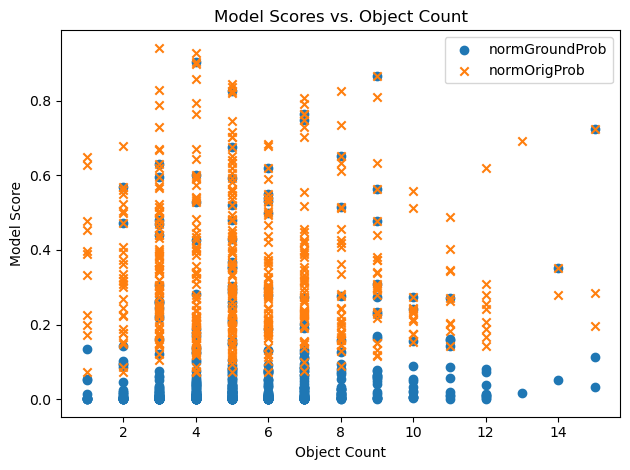

In [62]:
# plot size vs avgDeltaScore

df = pd.read_csv("/n/fs/obj-cv/experiment_project/experiments/equirectangularDataAnalysis/objectCount2Percent.csv")

# Plotting
plt.figure()
plt.scatter(df['objectCount'], df['normGroundProb'], marker='o', label='normGroundProb')
plt.scatter(df['objectCount'], df['normOrigProb'], marker='x', label='normOrigProb')
plt.xlabel('Object Count')
plt.ylabel('Model Score')
plt.title('Model Scores vs. Object Count')
plt.legend()
plt.tight_layout()
plt.show()

# Averages for each ground truth

In [93]:
# get each of the raw data csv files
raw_data_df_arr = []
data_folder = "/n/fs/obj-cv/experiment_project/experiments/objRemovalExp/dataFolder"
for ground_data in sorted( os.listdir(data_folder) ):
    df = pd.read_csv( os.path.join(data_folder, ground_data, "rawData.csv") )
    raw_data_df_arr.append(df)

# get the dataset paths as well
dataset_path_arr = []
dataset_folder = "/n/fs/obj-cv/infinigen_project/savedDatasets"
for ground_data in sorted( os.listdir(dataset_folder) ):
    dataset_path_arr.append( os.path.join( dataset_folder, ground_data) )

print(dataset_path_arr)
for df in raw_data_df_arr:
    print( df.loc[0]["groundName"] )

['/n/fs/obj-cv/infinigen_project/savedDatasets/bathroom97', '/n/fs/obj-cv/infinigen_project/savedDatasets/bedroom96', '/n/fs/obj-cv/infinigen_project/savedDatasets/diningRoom99', '/n/fs/obj-cv/infinigen_project/savedDatasets/kitchenDataset94', '/n/fs/obj-cv/infinigen_project/savedDatasets/livingRoom99']
bathroom
bedroom
dining_room
kitchen
living_room


In [72]:
# group by groundName; agg modelGroundProb, modelOrigProb, normGroundProb, normOrigProb
average_probs_df_arr = []
for df in raw_data_df_arr:
    # this doesn't mutate raw_data_df_arr
    df = df.groupby( "groundName" ).agg(
        avgModelGroundProb = ( 'modelGroundProb', 'mean' ),
        avgModelOrigProb = ( 'modelOrigProb', 'mean' ),
        avgNormGroundProb = ( 'normGroundProb', 'mean' ),
        avgNormOrigProb = ( 'normOrigProb', 'mean' ),
        stdModelGroundProb = ( 'modelGroundProb', 'std' ),
        stdgModelOrigProb = ( 'modelOrigProb', 'std' ),
        stdNormGroundProb = ( 'normGroundProb', 'std' ),
        stdNormOrigProb = ( 'normOrigProb', 'std' )
    )
    average_probs_df_arr.append(df)


df = pd.concat( average_probs_df_arr )
means = df.mean(numeric_only=True)
df.loc["average"] = means
df

,avgModelGroundProb,avgModelOrigProb,avgNormGroundProb,avgNormOrigProb,stdModelGroundProb,stdgModelOrigProb,stdNormGroundProb,stdNormOrigProb
groundName,,,,,,,,
bathroom,0.218803,0.358218,0.219025,0.435810,0.237381,0.238365,0.243356,0.223953
bedroom,0.059338,0.301367,0.063408,0.326288,0.077976,0.181224,0.078791,0.158456
dining_room,0.084711,0.290594,0.090856,0.319355,0.187518,0.196138,0.194611,0.188425
kitchen,0.054867,0.301830,0.061927,0.340268,0.113552,0.202655,0.119087,0.180327
living_room,0.037713,0.274121,0.044551,0.307951,0.056540,0.176962,0.068088,0.172563
average,0.091086,0.305226,0.095953,0.345935,0.134593,0.199069,0.140787,0.184745


# Object Size Correlation Matrix

In [7]:
# get each of the raw data csv files
raw_data_df_arr = []
data_folder = "/n/fs/obj-cv/experiment_project/experiments/objRemovalExp/dataFolder"
for ground_data in sorted( os.listdir(data_folder) ):
    df = pd.read_csv( os.path.join(data_folder, ground_data, "rawData.csv") )
    raw_data_df_arr.append(df)

# get the dataset paths as well
dataset_path_arr = []
dataset_folder = "/n/fs/obj-cv/infinigen_project/savedDatasets"
for ground_data in sorted( os.listdir(dataset_folder) ):
    dataset_path_arr.append( os.path.join( dataset_folder, ground_data) )

print(dataset_path_arr)
for df in raw_data_df_arr:
    print( df.loc[0]["groundName"] )

['/n/fs/obj-cv/infinigen_project/savedDatasets/bathroom97', '/n/fs/obj-cv/infinigen_project/savedDatasets/bedroom96', '/n/fs/obj-cv/infinigen_project/savedDatasets/diningRoom99', '/n/fs/obj-cv/infinigen_project/savedDatasets/kitchenDataset94', '/n/fs/obj-cv/infinigen_project/savedDatasets/livingRoom99']
bathroom
bedroom
dining_room
kitchen
living_room


In [8]:
# concat everything (across the 5 scenes)
df = pd.concat( raw_data_df_arr )
corr = df[['deltaGroundProb','deltaOrigProb','cumPixelsPercent']].corr()
print(corr['deltaGroundProb'].sort_values(ascending=False))
print()
print(corr['cumPixelsPercent'].sort_values(ascending=False))

deltaGroundProb     1.000000
deltaOrigProb       0.159823
cumPixelsPercent   -0.011026
Name: deltaGroundProb, dtype: float64

cumPixelsPercent    1.000000
deltaGroundProb    -0.011026
deltaOrigProb      -0.217619
Name: cumPixelsPercent, dtype: float64


In [9]:
# get the single data
# get each of the single data csv files
raw_data_df_arr = []
data_folder = "/n/fs/obj-cv/experiment_project/experiments/objRemovalExp/dataFolder"
for ground_data in sorted( os.listdir(data_folder) ):
    df = pd.read_csv( os.path.join(data_folder, ground_data, "single.csv") )
    raw_data_df_arr.append(df)

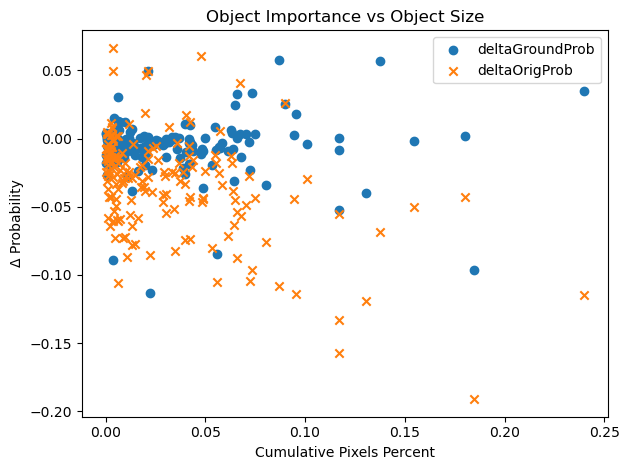

In [10]:
df = pd.concat( raw_data_df_arr )

plt.figure()
plt.scatter(df['cumPixelsPercent'], df['avgDeltaGroundProb'], marker='o', label='deltaGroundProb')
plt.scatter(df['cumPixelsPercent'], df['avgDeltaOrigProb'], marker='x', label='deltaOrigProb')
plt.xlabel('Cumulative Pixels Percent')
plt.ylabel('Δ Probability')
plt.title('Object Importance vs Object Size')
plt.legend()
plt.tight_layout()

plt.savefig("plot_300dpi.png", dpi=300)

plt.show()

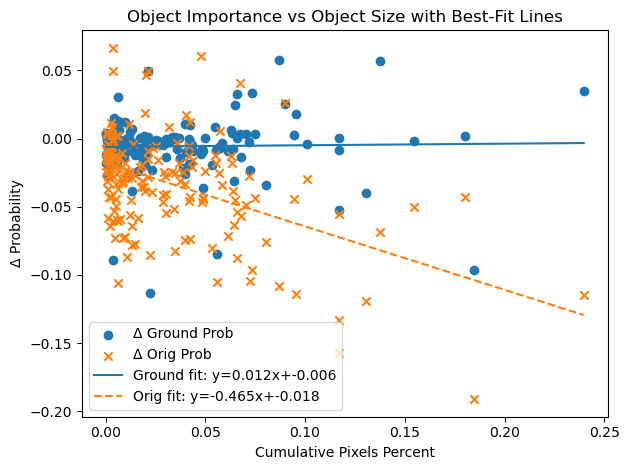

In [11]:
# your existing code
plt.figure()
plt.scatter(df['cumPixelsPercent'], df['avgDeltaGroundProb'], marker='o', label='Δ Ground Prob')
plt.scatter(df['cumPixelsPercent'], df['avgDeltaOrigProb'], marker='x', label='Δ Orig Prob')

# compute & plot fits
x = df['cumPixelsPercent'].values
x_line = np.linspace(x.min(), x.max(), 100)

# 1) Ground‐prob fit
y1 = df['avgDeltaGroundProb'].values
m1, b1 = np.polyfit(x, y1, 1)               # slope m1, intercept b1
plt.plot(x_line, m1*x_line + b1, '-',      
         label=f'Ground fit: y={m1:.3f}x+{b1:.3f}')

# 2) Orig‐prob fit
y2 = df['avgDeltaOrigProb'].values
m2, b2 = np.polyfit(x, y2, 1)
plt.plot(x_line, m2*x_line + b2, '--',   
         label=f'Orig fit: y={m2:.3f}x+{b2:.3f}')

# finishing touches
plt.xlabel('Cumulative Pixels Percent')
plt.ylabel('Δ Probability')
plt.title('Object Importance vs Object Size with Best‑Fit Lines')
plt.legend()
plt.tight_layout()
plt.show()

# Bar Chart for Important Objects

In [5]:
# get the single data
# get each of the single data csv files
single_data_df_arr = []
data_folder = "/n/fs/obj-cv/experiment_project/experiments/objRemovalExp/dataFolder"
for ground_data in sorted( os.listdir(data_folder) ):
    df = pd.read_csv( os.path.join(data_folder, ground_data, "single.csv") )
    single_data_df_arr.append(df)

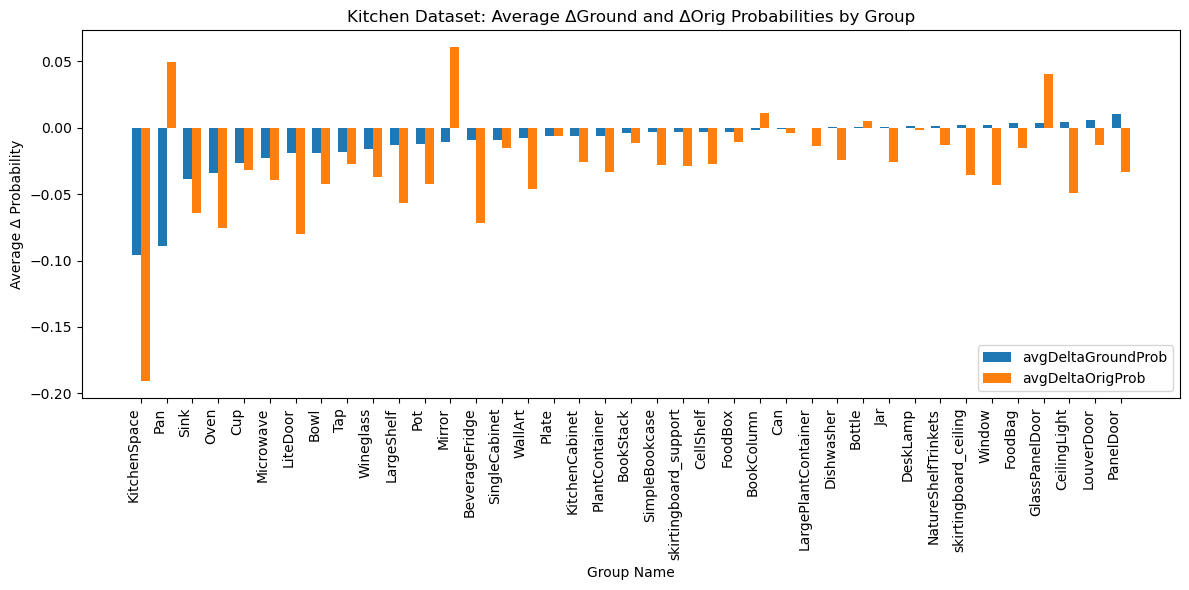

In [28]:
df = single_data_df_arr[3]
# choose one sorting metric
df = df.sort_values(by = "avgDeltaGroundProb")
# df = df.sort_values(by = "avgDeltaOrigProb")
# df = df.sort_values(by = "cumPixelsPercent", ascending=False)

import matplotlib.pyplot as plt

# Assume `df` is your DataFrame and its index is `groupName`
groups = df["groupName"].tolist()
x = range(len(groups))
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Bars for avgDeltaGroundProb
ax.bar(x, 
       df['avgDeltaGroundProb'], 
       width, 
       label='avgDeltaGroundProb')

# Bars for avgDeltaOrigProb, shifted by `width`
ax.bar([i + width for i in x], 
       df['avgDeltaOrigProb'], 
       width, 
       label='avgDeltaOrigProb')

# Ticks and labels
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(groups, rotation=90, ha='right')
ax.set_xlabel('Group Name')
ax.set_ylabel('Average Δ Probability')
ax.set_title('Kitchen Dataset: Average ΔGround and ΔOrig Probabilities by Group')
ax.legend()

plt.tight_layout()

# Save with 300 DPI
plt.savefig("plot_300dpi.png", dpi=300)


plt.show()
